# Agrupamiento K-means
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

El clustering (Agrupamiento) consiste en la agrupación automática de datos. Es un tipo de aprendizaje automático no-supervisado. Los algoritmos de agrupamiento buscan aprender, a partir de las propiedades de los datos, una división óptima o etiquetado discreto de grupos de puntos.

Muchos algoritmos de agrupamiento están disponibles en Scikit-Learn y en otros lugares, pero quizás el más simple de entender es un algoritmo conocido como agrupamiento k-means, que se implementa en sklearn.cluster.KMeans.

Primero importamos las librerias más importantes que usaremos a lo largo del Notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Introduciendo a K-means

El algoritmo k -means busca un número predeterminado de grupos dentro de un conjunto de datos multidimensional sin etiquetar. Logra esto utilizando una concepción simple de cómo se ve el agrupamiento óptimo:

- El "centro del grupo" es la media aritmética de todos los puntos que pertenecen al grupo.
- Cada punto está más cerca de su propio centro de conglomerado que de otros centros de conglomerados.

Esos dos supuestos son la base del modelo de k -medias. Pronto nos sumergiremos en exactamente cómo el algoritmo llega a esta solución, pero por ahora echemos un vistazo a un conjunto de datos simple y veamos el resultado k -means.

Primero, generemos un conjunto de datos bidimensional que contenga cuatro blobs distintos. Para enfatizar que este es un algoritmo no supervisado, dejaremos las etiquetas fuera de la visualización:

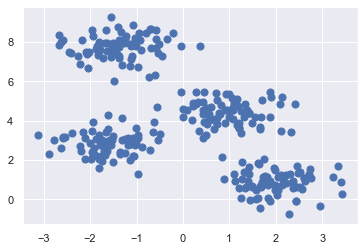

In [2]:
#Importamos make_blobs, esto genera puntos gaussianos isotrópicos
from sklearn.datasets import make_blobs

# Generamos los puntos tanto en X como en Y, seteamos la configuración: 4 centros de cúmulos, con una desviación estandar de 60
# cada uno. 
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
#Graficamos
plt.scatter(X[:, 0], X[:, 1], s=50);

A simple vista se pueden identificar los 4 grupos de cumulos de blobs, pero el algoritmo K-means lo hace automáticamente. A continuación, podemos ver como se implementa:

In [3]:
#Importamos K-means de sklearn.cluster
from sklearn.cluster import KMeans
#Usamos K-means, establecemos un número de cúmulos igual 4
kmeans = KMeans(n_clusters=4)
#Ajustamos los datos
kmeans.fit(X)
#Calcula los centros de cúmulos y predice el índice de los cúmulos para cada muestra.
y_kmeans = kmeans.predict(X)

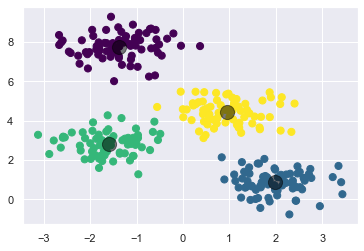

In [4]:
#Graficamos los puntos, establecemos las propiedades de la gráfica
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

#Graficamos los centros, establecemos las propiedades de los mismos
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

K-means asigna los puntos a los grupos de manera muy similar a cómo los asignaríamos a simple vista. ¡Pero quizás se pregunte cómo este algoritmo encuentra estos grupos tan rápido! Después de todo, la cantidad de combinaciones posibles de asignaciones de grupos es exponencial en la cantidad de puntos de datos: una búsqueda exhaustiva sería muy, muy costosa. Afortunadamente para nosotros, una búsqueda tan exhaustiva no es necesaria: en cambio, el enfoque típico de K-means implica un enfoque iterativo intuitivo conocido como expectativa-maximización.

## Algoritmo K-means: Expectativa–Maximización

La maximización de expectativas (E–M) es un algoritmo poderoso que surge en una variedad de contextos dentro de la ciencia de datos. k -means es una aplicación del algoritmo particularmente simple y fácil de entender, y la analizaremos brevemente aquí. En resumen, el enfoque de maximización de expectativas aquí consiste en el siguiente procedimiento:
<ol>
    <li>Adivina algunos centros de racimo</li>
    <li>Repetir hasta converger</li>
    <ul>
        <li>E-Step : asigna puntos al centro del clúster más cercano</li>
        <li>M-Step : establezca los centros de los clústeres en la media</li>
    </ul>
</ol>
Aquí, el "paso E" o "paso de expectativa" se llama así porque implica actualizar nuestra expectativa de a qué grupo pertenece cada punto. El "paso M" o "paso de maximización" se llama así porque implica maximizar alguna función de aptitud que define la ubicación de los centros del conglomerado; en este caso, esa maximización se logra tomando una media simple de los datos en cada conglomerado.

A continuación, en el siguiente bloque de código veremos el algoritmo K-means en su escencia pura, la forma más simplificada y funcional del algoritmo:

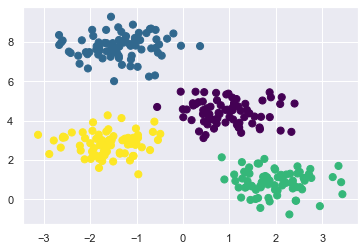

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Elija aleatoriamente los clústeres (o cúmulos)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Asigne etiquetas en función del centro más cercano
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Encuentre nuevos centros a partir de medios de puntos
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Compruebe la convergencia
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)

#Graficamos
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

La mayoría de las implementaciones bien probadas harán un poco más que esto bajo el capó, pero la función anterior proporciona la esencia del enfoque de maximización de expectativas.

## Advertencias de expectativa–maximización 

Existen algunos **inconvenientes** que se podrían presentar a la hora de usar el **algoritmo de expectativa-maximización**.

### Es posible que no se logre el resultado globalmente óptimo

Primero, aunque se garantiza que el procedimiento E-M mejorará el resultado en cada paso, no hay garantía de que conduzca a la mejor solución global . Por ejemplo, si usamos una semilla aleatoria diferente en nuestro procedimiento simple, las conjeturas iniciales particulares conducen a resultados deficientes:

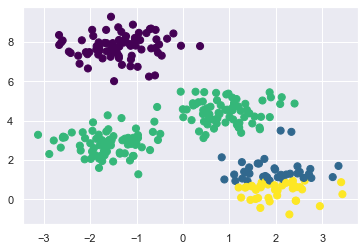

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Aquí el enfoque E-M ha convergido, pero no ha convergido a una configuración globalmente óptima. Por esta razón, es común que el algoritmo se ejecute para varias conjeturas iniciales, como lo hace Scikit-Learn de manera predeterminada (establecido por el n_initparámetro, que tiene un valor predeterminado de 10).

### El número de clústeres debe seleccionarse previamente 

Otro desafío común con k -means es que debe decirle cuántos grupos espera: no puede aprender el número de grupos de los datos. Por ejemplo, si le pedimos al algoritmo que identifique seis grupos, procederá felizmente y encontrará los mejores seis grupos:

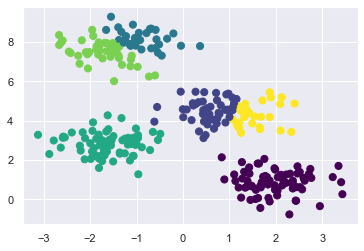

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Si el resultado es significativo es una pregunta difícil de responder de manera definitiva; un enfoque que es bastante intuitivo, pero que no discutiremos más aquí, se llama análisis de silueta.

### k-means se limita a los límites del clúster lineal

Los supuestos fundamentales del modelo de k -means (los puntos estarán más cerca de su propio centro de conglomerado que de otros) significa que el algoritmo a menudo será ineficaz si los conglomerados tienen geometrías complicadas.

En particular, los límites entre los grupos de k -medias siempre serán lineales, lo que significa que fallará para límites más complicados. Considere los siguientes datos, junto con las etiquetas de conglomerados encontradas por el enfoque típico de k -medias:

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

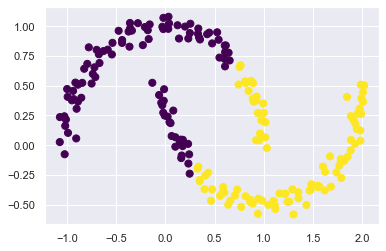

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Esta situación recuerda la discusión en Support Vector Machines, donde usamos una transformación del núcleo para proyectar los datos a una dimensión superior donde es posible una separación lineal. Podríamos imaginarnos usando el mismo truco para permitir que K-means descubra límites no lineales.

Una versión de este K-means kernelizado se implementa en Scikit-Learn dentro del SpectralClusteringestimador. Utiliza el gráfico de los vecinos más cercanos para calcular una representación de mayor dimensión de los datos y luego asigna etiquetas usando un algoritmo K-means:

C:\Users\JuanMa\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


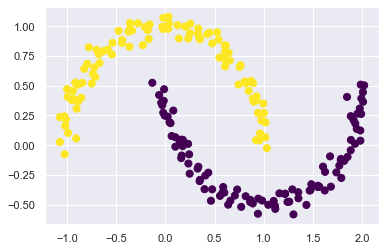

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Vemos que con este enfoque de transformación del kernel, el K-means kernelizado puede encontrar los límites no lineales más complicados entre los clústeres.

## Ejemplos

Teniendo cuidado con estas limitaciones del algoritmo, podemos usar k -means a nuestro favor en una amplia variedad de situaciones. Ahora vamos a echar un vistazo a un par de ejemplos.

### Ejemplo 1: k-medias en dígitos

Este es el mismo ejemplo que usamos en Árboles de decisión y Bosques Aleatorios, aquí intentaremos usar K-means para tratar de identificar dígitos similares sin usar la información de la etiqueta original; esto podría ser similar a un primer paso para extraer el significado de un nuevo conjunto de datos sobre el cual no tiene ninguna información de etiqueta a priori.

Primero cargamos los datos, luego almacenamos estos datos en una variable llamada **digits**:

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

 El dataset consta de 1797 muestras con 64 características donde cada una de las 64 características es el brillo de un píxel en una imagen de 8×8.

Hacemos la agrupación a nuestro gusto:

In [12]:
#Usamos K-means, establecemos un número de cúmulos igual 10
kmeans = KMeans(n_clusters=10, random_state=0)
#Calcula los centros de cúmulos y predice el índice de los cúmulos para cada muestra
clusters = kmeans.fit_predict(digits.data)
#imprimimos la forma en la que vienen los datos
kmeans.cluster_centers_.shape

(10, 64)

El resultado son 10 clústeres en 64 dimensiones. Tenga en cuenta que los propios centros del grupo son puntos de 64 dimensiones y pueden interpretarse como el dígito "típico" dentro del grupo. Veamos cómo se ven estos centros de conglomerados:

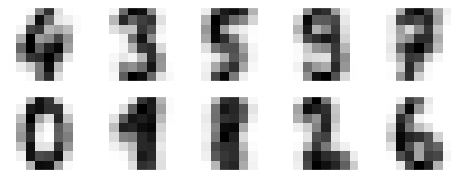

In [13]:
#Definimos fig, que son las figuras y ax que son los ejes, los subplots serán los números, ubicados en una una matriz 2x5
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
#Definimos los centros, que serán de 10 números por cúmulo, y cada número medirá 8*8 píxeles
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
#Iteramos el for para imprimir la imágen  
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Vemos que incluso sin las etiquetas, K-means es capaz de encontrar grupos cuyos centros son dígitos reconocibles, quizás con la excepción de 1 y 8.

Debido a que K-means no sabe nada sobre la identidad del grupo, las etiquetas 0–9 pueden permutarse. Podemos arreglar esto haciendo coincidir cada etiqueta de clúster aprendida con las etiquetas verdaderas que se encuentran en ellos:

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Ahora podemos verificar qué tan precisa fue nuestra agrupación no supervisada para encontrar dígitos similares dentro de los datos:

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

La presición fue casi del 80% de los dígitos de entrada.

Trazamos la matriz de confusion para visualizar estos resultados:

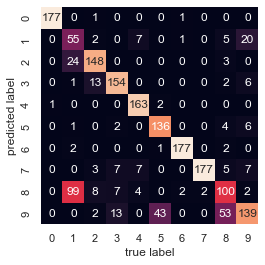

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Como cabría esperar de los centros de los cúmulos que visualizamos antes, el principal punto de confusión está entre los ochos y los unos. ¡Pero esto todavía muestra que usando k -means, podemos construir esencialmente un clasificador de dígitos sin referencia a ninguna etiqueta conocida!

Esto se puede llevar a otro nivel, y mejorar el resultado anteriormente obtenido, si usamos un preprocesamiento de los datos antes de aplicar K-means. El algoritmo es T-SNE, este es un algoritmo de incrustación no lineal que es particularmente hábil para preservar puntos dentro de grupos. Veamos cómo lo hace:

In [17]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

C:\Users\JuanMa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.9432387312186978

Eso es casi un 92% de precisión de clasificación sin usar las etiquetas. Este es el poder del aprendizaje no supervisado cuando se usa con cuidado: puede extraer información del conjunto de datos que podría ser difícil de hacer a mano o a simple vista.

**Conclusión del Ejercicio:** Si únicamente tenemos en cuenta a el algoritmo puro, sin preprocesamiento, la matriz de confusión arroja que el algoritmo, evidentemente tuvo un acierto de aproximadamente el 80%, es bueno, pero para este tipo de aprendizaje automático no-supervisado, puede llegar a ser un poco impreciso a comparación del algoritmo de Los Bosques Aleatorios, pues obtuvieron una precisión de casi el 100% en todos los dígitos. 

Posiblemente esto depende del tipo de tarea que se le de a K-means, y puede que la agrupación de elementos con patrones como los puntos sea el punto fuerte de este algoritmo, por ejemplo, este podría ser usado para tareas de agrupamientos de súpercumulos de galaxias en las fotografias de los telescopios.

## Ejemplo 2: k -means para compresión de color

Una aplicación interesante del agrupamiento es la compresión de color dentro de las imágenes. Por ejemplo, imagina que tienes una imagen con millones de colores. En la mayoría de las imágenes, una gran cantidad de colores no se usarán y muchos de los píxeles de la imagen tendrán colores similares o incluso idénticos.

Por ejemplo, considere la imagen que se muestra en la siguiente figura, que es del módulo Scikit-Learn datasets(para que esto funcione, deberá tener pillowinstalado el paquete Python).

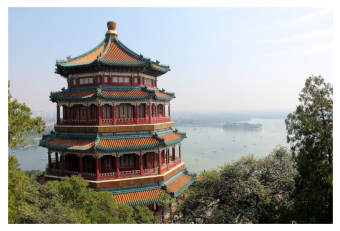

In [18]:
#Importamos la imagen desde el dataset de sklearn
from sklearn.datasets import load_sample_image
#Almacenamos la imagen en una variable
china = load_sample_image("china.jpg")
#Definimos los ejes de la imagen para graficarla
ax = plt.axes(xticks=[], yticks=[])
#Mostramos la imagen
ax.imshow(china);

La imagen en sí se almacena en una matriz tridimensional de tamaño (height, width, RGB), que contiene contribuciones de rojo/azul/verde como números enteros de 0 a 255:

Imprimimos una tupla con la forma de la imagen, (427px de alto, 640 de ancho)

In [19]:
china.shape

(427, 640, 3)

Una forma en que podemos ver este conjunto de píxeles es como una nube de puntos en un espacio de color tridimensional. Reformaremos los datos a [n_samples x n_features], y cambiaremos la escala de los colores para que estén entre 0 y 1:

In [20]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Podemos visualizar estos píxeles en este espacio de color, usando un subconjunto de 10 000 píxeles para mayor eficiencia:

In [21]:
#Definimos una función para graficar los píxeles
def plot_pixels(data, title, colors=None, N=10000):
    #Si no hay colores, toma los colores que te pasamos en la data
    if colors is None:
        colors = data
    
    # elige un subconjunto aleatorio
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

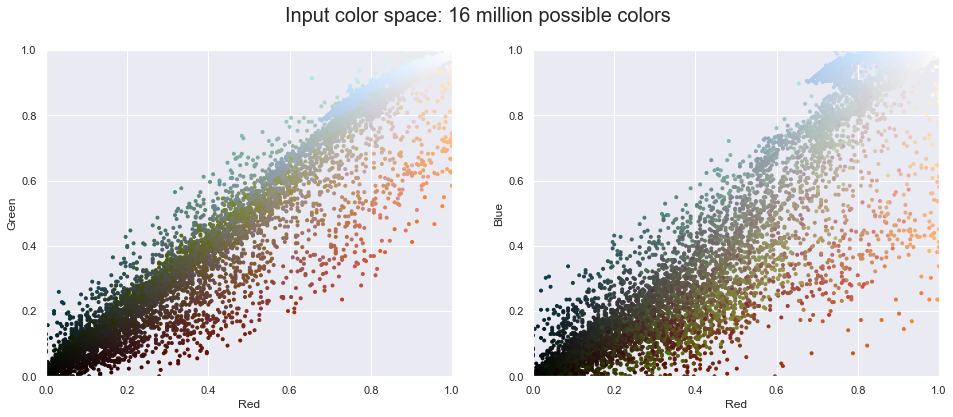

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Ahora, reduzcamos estos 16 millones de colores a solo 16 colores, usando un agrupamiento de K-means en el espacio de píxeles. Debido a que estamos tratando con un conjunto de datos muy grande, usaremos el mini lote K-means, que opera en subconjuntos de datos para calcular el resultado mucho más rápido que el algoritmo estándar K-means:

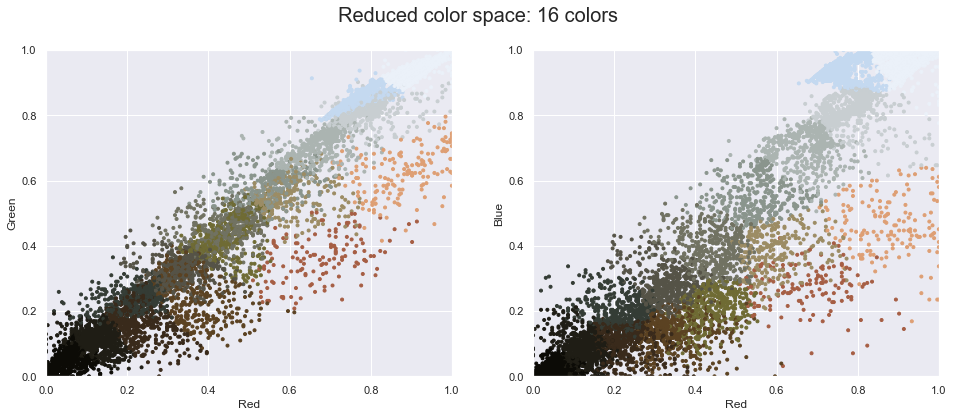

In [23]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

El resultado es una nueva coloración de los píxeles originales, donde a cada píxel se le asigna el color de su centro de grupo más cercano. Trazar estos nuevos colores en el espacio de la imagen en lugar del espacio de píxeles nos muestra el efecto de esto:

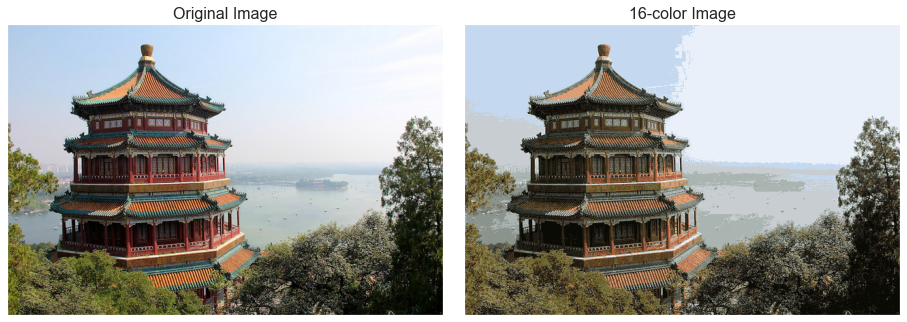

In [24]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

La imagen de la derecha es la que está comprimida, evidentemente se pierden detalles respecto a la imagen original, pero hay que tener en cuenta que es una  compresión de alrededor de 1 millón, Si bien esta es una aplicación interesante de K-means, ciertamente hay mejores formas de comprimir información en imágenes. Pero el ejemplo muestra el poder de pensar fuera de la caja con métodos no supervisados como K-means.

**Conclusión del Ejercicio:** el algoritmo de K-means prueba ser bastante eficiente en la compresion de color de las imágenes, aunque el resultado puede dejar mucho que desear si se compara con algún software especializado, K-means puede ser mucho más pulido si se implementan otras tecnicas que complementen el algoritmo, por ejemplo si se implementan los preprocesadores, quizas podriamos obtener una mejor definición y poca perdida de detalles.

## Conclusión

**K-Means** es la técnica de clustering más usada de entre las muchas que hay ya que tiene una muy buena escalabilidad con la cantidad de datos. Agrupar datos con **K-means** es muy útil para aplicaciones tales como segmentación de clientes, compresión con pérdida de datos. También para encontrar entidades con comportamientos similares.
Además, **K-means** tiene una variación llamada **Expectativa-Maximización**  que perfecciona los procesos de clasificación y agrupamiento implementando una técnica iterativa general para realizar una estimación de máxima verosimilitud
de parámetros de problemas en los que existen ciertos datos ocultos.

Pero tiene una desventaja muy grande y es que la naturaleza no probabilística de K-means y su uso de la simple distancia desde el centro del clúster para asignar la membresía del clúster conduce a un rendimiento deficiente en muchas situaciones del mundo real y sumado a esto, k-Means puede llegar a ser lento para un volumen muy grande de datos debido al su caracter iterativo.